# Data models

In [27]:
from typing import List
from typing import Callable
from typing import Tuple

class Rectangle:
    
    def __init__(self, width=0, height=0, x=0, y=0, ident=1):
        self.width = width
        self.height = height
        self.x = x
        self.y = y
        self.ident = ident
        self.centerX = x+width/2
        self.centerY = y+height/2
    
    def __str__(self):
        return f'{self.ident}: ({self.width},{self.height},{self.x},{self.y}) whxy'
    
def decodeIntList(lst: List[str]) -> List[int]:
    return list(map(int, lst))

def decodeFloatList(lst: List[str]) -> List[float]:
    return list(map(float, lst))

def decodeRectangles(lst: List[str], idents: List[str]) -> List[Rectangle]:
    return list(map(decodeRectangle, *(lst,idents)))

def decodeRectangle(rec: str, ident: str) -> Rectangle:
    x,y,w,h = rec.split(',')
    return Rectangle(x=int(x), y=int(y), width=int(w), height=int(h), ident=ident)


class Individual:
    def __init__(self, iteration: int, objectiveValue: int, paintingSeq: List[int], paintingSeqDecoded: List[int], paintingSeqRandomKey: List[float], slicingOrderDecoded: List[int], slicingOrderRandomKey: List[float], orientations: List[str], orientationsCapped: List[str], orientationsResolved: List[str], paintingAllocatedSpace: List[Rectangle], paintingPlacement: List[Rectangle]):
        self.iteration = iteration
        self.objectiveValue = objectiveValue
        self.paintingSeq = paintingSeq
        self.paintingSeqDecoded = paintingSeqDecoded
        self.paintingSeqRandomKey = paintingSeqRandomKey
        self.slicingOrderDecoded = slicingOrderDecoded
        self.slicingOrderRandomKey = slicingOrderRandomKey
        self.orientations = orientations
        self.orientationsCapped = orientationsCapped
        self.orientationsResolved = orientationsResolved
        self.paintingAllocatedSpace = paintingAllocatedSpace
        self.paintingPlacement = paintingPlacement
        
    @staticmethod
    def create(json: dict) -> 'Individual':
        return Individual(
            iteration=int(json['iteration']),
            objectiveValue=float(json['objectiveValue']),
            paintingSeq=json['paintingSeq'],
            paintingSeqDecoded=json['paintingSeqDecoded'],
            paintingSeqRandomKey=decodeFloatList(json['paintingSeqRandomKey']),
            slicingOrderDecoded=decodeIntList(json['slicingOrderDecoded']),
            slicingOrderRandomKey=decodeFloatList(json['slicingOrderRandomKey']),
            orientations=json['orientations'],
            orientationsCapped=json['orientationsCapped'],
            orientationsResolved=json['orientations'], # TODO provide resolved orientations
            paintingAllocatedSpace=decodeRectangles(json['paintingAllocatedSpace_XYWH'], json['paintingSeqDecoded']),
            paintingPlacement=decodeRectangles(json['paintingPlacement_XYWH'], json['paintingSeqDecoded']))
    
class Painting:
    def __init__(self, ident: str, width: int, height: int):
        self.ident = ident
        self.width = width
        self.height = height
        
    @staticmethod
    def create(json: dict) -> 'Painting':
        return Painting(
            ident=json['ident'],
            width=int(json['width']),
            height=int(json['height']))
    
class HallOfFameRecord:
    def __init__(self, iteration: int, objectiveMin: float, objectiveMax: float, objectiveAvg: float, bestIndividual: Individual):
        self.iteration = iteration
        self.objectiveMin = objectiveMin
        self.objectiveMax = objectiveMax
        self.objectiveAvg = objectiveAvg
        self.bestIndividual = bestIndividual
    
    @staticmethod
    def create(json: dict) -> 'HallOfFameRecord':
        return HallOfFameRecord(
            iteration=int(json['iteration']),
            objectiveMin=float(json['objectiveMin']),
            objectiveMax=float(json['objectiveMax']),
            objectiveAvg=float(json['objectiveAvg']),
            bestIndividual=Individual.create(json['bestIndividual']))
            
class GaResult:
    def __init__(self, bestIndividual: Individual, hallOfFame: List[HallOfFameRecord]):
        self.bestIndividual = bestIndividual
        self.hallOfFame = hallOfFame
        
    @staticmethod
    def create(json: dict) -> 'GaResult':
        return GaResult(
            bestIndividual=Individual.create(json['bestIndividual']),
            hallOfFame=list(map(HallOfFameRecord.create, json['hallOfFame']['records'])))
    
class GaParameters:
    def __init__(self, maxNumberOfIter: int, populationSize: int, geneticAlgorithm: str, mate: str, mutate: str, select: str):
        self.maxNumberOfIter = maxNumberOfIter
        self.populationSize = populationSize
        self.geneticAlgorithm = geneticAlgorithm
        self.mate = mate
        self.mutate = mutate
        self.select = select
        
    @staticmethod
    def create(json: dict) -> 'GaParameters':
        return GaParameters(
            maxNumberOfIter=int(json['maxNumberOfIter']),
            populationSize=int(json['populationSize']),
            geneticAlgorithm=json['geneticAlgorithm'],
            mate=json['mate'],
            mutate=json['mutate'],
            select=json['select'])

class Layout:
    def __init__(self, width: int, height: int, evalFunc: str):
        self.width = width
        self.height = height
        self.evalFunc = evalFunc
        self.boundingRectangle = Rectangle(width=width, height=height, x=0, y=0, ident="")
        
    @staticmethod
    def create(json: dict) -> 'Layout':
        return Layout(width=json['width'], height=json['height'], evalFunc=json['evalFunc'])
    
class Flow:
    def __init__(self, src: int, dst: int, flow: float):
        self.src = src
        self.dst = dst
        self.flow = flow
        
    @staticmethod
    def create(json: dict) -> 'Flow':
        return Flow(
            src=int(json['from']),
            dst=int(json['to']),
            flow=float(json['flow']))
    
class InstanceParameters:
    def __init__(self, layout: Layout, paintings: List[Painting], paintingsFlow: List[Flow]):
        self.layout = layout
        self.paintings = paintings
        self.paintingsFlow = paintingsFlow
        
    @staticmethod
    def create(json: dict) -> 'InstanceParameters':
        return InstanceParameters(
            layout=Layout.create(json['layout']),
            paintings=list(map(Painting.create, json['paintings'])),
            paintingsFlow=list(map(Flow.create, json['paintingsFlow'])))
    
class ObjectiveParameters:
    def __init__(self, name: str, params: dict):
        self.name = name
        self.params = params
        
    @staticmethod
    def create(json: dict) -> 'ObjectiveParameters':
        return ObjectiveParameters(
            name=json['name'],
            params=json['params'])
        

class ComputationResult:
    def __init__(self, applicationVersion: str, createdAt: str, durationMillis: int, gaResult: GaResult, gaParameters: GaParameters, instanceParameters: InstanceParameters, objectiveParameters: ObjectiveParameters, name: str = None):
        self.applicationVersion = applicationVersion
        self.createdAt = createdAt
        self.durationMillis = durationMillis
        self.gaResult = gaResult
        self.gaParameters = gaParameters
        self.instanceParameters = instanceParameters
        self.objectiveParameters = objectiveParameters
        self.name = name
        
    @staticmethod
    def createWithName(name: str, json: dict):
        compRes = ComputationResult.create(json)
        compRes.name = name
        return compRes
    
    @staticmethod
    def create(json: dict) -> 'ComputationResult':
        return ComputationResult(
            applicationVersion=json['applicationVersion'],
            createdAt=json['createdAt'],
            durationMillis=int(json['durationMillis']),
            gaResult=GaResult.create(json['gaResult']),
            gaParameters=GaParameters.create(json['gaParameters']),
            instanceParameters=InstanceParameters.create(json['instanceParameters']),
            objectiveParameters=ObjectiveParameters.create(json['objectiveParameters']))
    
class Dataset:
    def __init__(self, name: str, instanceParameters: InstanceParameters):
        self.name = name
        self.instanceParameters = instanceParameters
        self.data = instanceParameters
        
    @staticmethod
    def create(json: dict) -> 'Dataset':
        return Dataset(
            name=json['name'],
            instanceParameters=InstanceParameters.create(json['data']))

## Loading computation result

In [28]:
from pathlib import Path
import json

def _getDirPrefix(name: str) -> int:
    return int(name.split('_')[0])

def loadLatestComputationResult(resultDir='/home/slarty/Documents/master-thesis/src/impl/out') -> ComputationResult:
    dirs = [x for x in Path(resultDir).iterdir() if x.is_dir()]
    latest, prefix = dirs[0], _getDirPrefix(dirs[0].name)
    for d in dirs:
        k = _getDirPrefix(d.name)
        if k > prefix:
            latest, prefix = d, k
    return loadComputationResult(str(latest.resolve()))

def loadComputationResult(path: str, compResultFileName='computation_result.json') -> ComputationResult:
    print(f'loading: {path}')
    with open(path + '/' + compResultFileName, 'r') as f:
        data = json.load(f)
    return ComputationResult.createWithName(path.split('/')[-1], data)

## Loading dataset

In [29]:
import os
import fnmatch
import json

def findDatasetPath(name, datasetDir='../datasets') -> str:
    for root, dirs, files in os.walk(datasetDir):
        for filename in fnmatch.filter(files, f"{name}.json"):
            return os.path.join(root, filename)
    raise FileNotFoundError(f"No file found with name {name}.json in directory {datasetDir}")

def loadDataset(name, datasetDir='/home/slarty/Documents/master-thesis/src/impl/public/datasets') -> Dataset:
    path = findDatasetPath(name, datasetDir)
    print(f'Loading {path}')
    with open(path, 'r') as f:
        data = json.load(f)
    return Dataset.create(data)


## Flow matrix

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/random/random_20.json


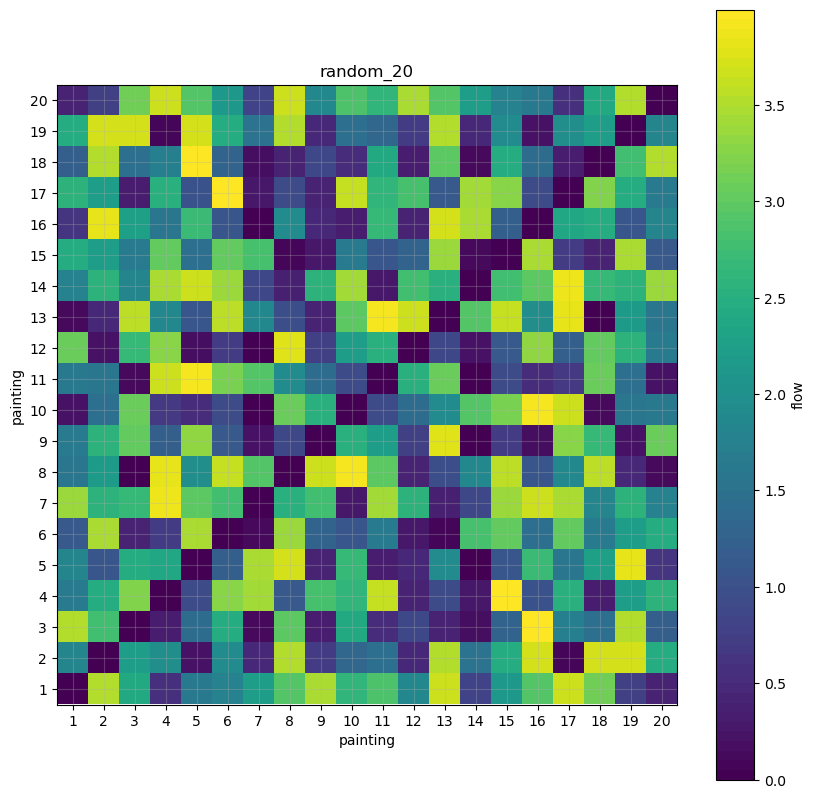

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/cluster/cluster_3_10.json


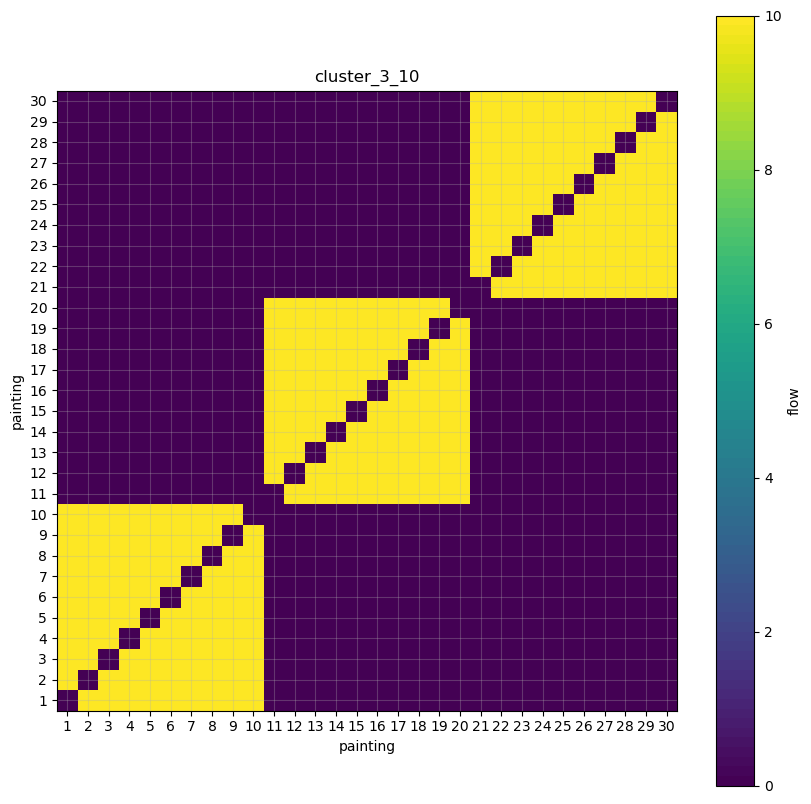

Loading /home/slarty/Documents/master-thesis/src/impl/public/datasets/cluster/cluster_4_20.json


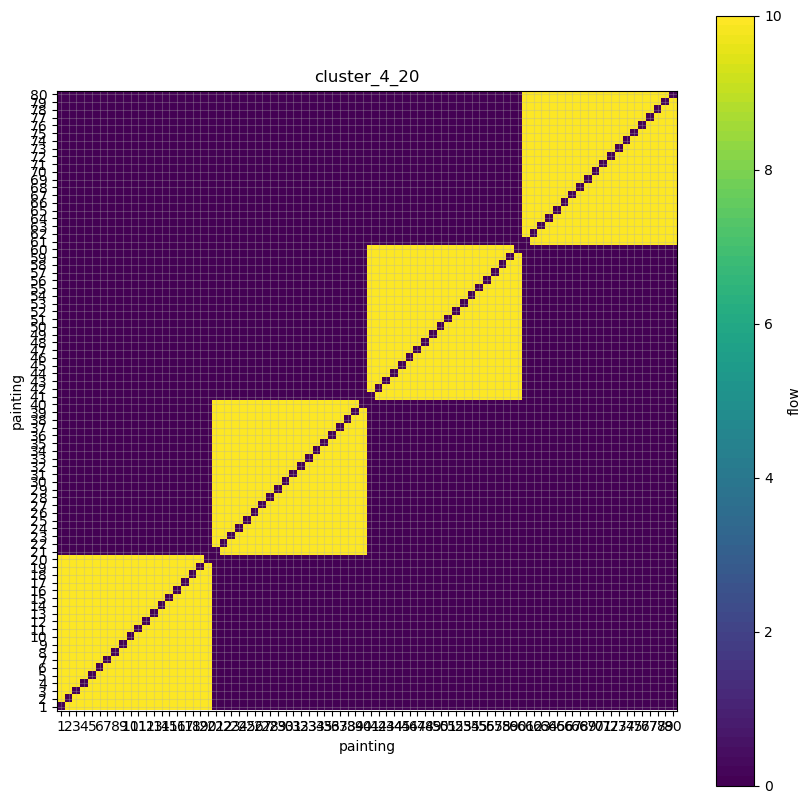

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as CM

for name, size in [('random_20', 20), ('cluster_3_10', 30), ('cluster_4_20', 80)]:
    dataset = loadDataset(name)
    flows = np.zeros((size,size), dtype=float)
    for f in dataset.data.paintingsFlow:
        x,y = size-f.src, f.dst-1
        flows[x,y] = f.flow
        flows[size-x-1, size-y-1] = f.flow
        
    # A = flows
    # mask = np.rot90(np.tri(flows.shape[0], k=-1), k=3)
    # A = np.ma.array(A, mask=mask) # mask out the lower triangle
    # cmap = CM.get_cmap('viridis', size) # jet doesn't have white color
    # cmap.set_bad('w') # default value is 'k'
    # print(flows)
    A = flows
    # print(A)
    
    fig = plt.figure(figsize=(10, 10))
    plt.xlabel('painting')
    plt.ylabel('painting')
    plt.xticks(range(0,size), range(1,size+1))
    plt.yticks(range(0,size), range(size, 0, -1))
    plt.imshow(A, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.grid(True, alpha=0.3)
    cbar = plt.colorbar()
    cbar.set_label('flow')
    plt.savefig(f"figures/heatmap_{name}.pdf")
    plt.show()

## Population size x best solution

In [31]:
r.instanceParameters.paintingsFlow[0].flow

NameError: name 'r' is not defined